In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Principle Component Analysis

We can do principle component analysis to reduce the dimensionality across the repair outcomes to help identify the repair outcomes which result in the best seperation of the repair outcome profiles

In [69]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from src.data.load_dataset import load_lumc_outcomes
from src.config import get_common_barcodes

In [70]:
# takes about 6 minutes to load the data into memory
df = load_lumc_outcomes(sample_name="MB06")
df.head()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


/Users/colm/repos/MUSICian/src/data/load_dataset.py:78: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx[["fraction_per_barcode"]].sum(level=["Alias", "Gene", "Barcode"])


Normalised per Gene


fraction_per_barcode  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.003527   
                    0610009B22Rik-1              0.007053   
                    0610009B22Rik-1              0.223354   
                    0610009B22Rik-1              0.002351   
                    0610009B22Rik-1              0.032915   

                                                  lumc_category  del_len  \
Alias Gene          Barcode                                                
MB06  0610009B22Rik 0610009B22Rik-1           1bp insertion - A        0   
                    0610009B22Rik-1           1bp insertion - C        0   
                    0610009B22Rik-1           1bp insertion - G        0   
                    0610009B22Rik-1              >1bp insertion        0   
                    0610009B22Rik-1  Deletion 0bp microhomology        1   

                                     countEvents  
Alias Gene          Barcode                       
MB06  0610009B22Rik 0610009B22Rik-1            9  
                    0610009B22Rik-1           18  
                    0610009B22Rik-1          570  
                    0610009B22Rik-1            6  
                    0610009B22Rik-1           84

In [71]:
common_barcodes = pd.read_csv(get_common_barcodes(), sep="\t")
common_barcodes = common_barcodes[common_barcodes["Filtered"] == 0]["Barcode"]
common_barcodes.shape

(497700,)

### Do our categories capture the variation in repair outcomes between target sites?

Run PCA analysis on Target Site/Replicate/gRNA x Outcomes 

In [72]:
df.head()

fraction_per_barcode  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.003527   
                    0610009B22Rik-1              0.007053   
                    0610009B22Rik-1              0.223354   
                    0610009B22Rik-1              0.002351   
                    0610009B22Rik-1              0.032915   

                                                  lumc_category  del_len  \
Alias Gene          Barcode                                                
MB06  0610009B22Rik 0610009B22Rik-1           1bp insertion - A        0   
                    0610009B22Rik-1           1bp insertion - C        0   
                    0610009B22Rik-1           1bp insertion - G        0   
                    0610009B22Rik-1              >1bp insertion        0   
                    0610009B22Rik-1  Deletion 0bp microhomology        1   

                                     countEvents  
Alias Gene          Barcode                       
MB06  0610009B22Rik 0610009B22Rik-1            9  
                    0610009B22Rik-1           18  
                    0610009B22Rik-1          570  
                    0610009B22Rik-1            6  
                    0610009B22Rik-1           84

In [73]:
df.groupby(["Alias", "Barcode"]).sum().head()

fraction_per_barcode  del_len  countEvents
Alias Barcode                                                    
MB06  0610009B22Rik-1                   1.0      479         2552
      0610009B22Rik-2                   1.0      570         3630
      0610009B22Rik-3                   1.0      766         4053
      0610009B22Rik-4                   1.0      849         4752
      0610009B22Rik-5                   1.0      476         2723

In [110]:
df = df.reset_index()
X = df[df["Barcode"].isin(common_barcodes)]
X = X[X["Alias"] == "MB06"]

In [111]:
# from src.config import get_hussmann_supplementary_xlsx, HOME_PATH

# hussmann_repair_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.lower()
# hussmann_repair_genes.shape

# genesubset2 = pd.read_csv(HOME_PATH + "/repos/MUSICian/src/data/GeneSubset2.txt", sep="\t")["Gene"]
# genesubset2.head()

# # X = X[X["Gene"].str.lower().isin(hussmann_repair_genes)]
# X = X[X["Gene"].isin(genesubset2)]
# X

In [112]:
X["Feature"] = X["lumc_category"] + ", " + X["del_len"].astype(str)  + ", " + X["del_len"].astype(str)

In [113]:
X.groupby(["Alias", "Barcode"]).size().groupby(["Alias"]).size()

Alias
MB06    82950
dtype: int64

In [114]:
X = X.pivot(index=["Alias", "Gene", "Barcode"], columns=["Feature"], values="fraction_per_barcode").fillna(0)
X.head()

Feature                              1bp insertion - A, 0  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.003527   
                    0610009B22Rik-2              0.000000   
                    0610009B22Rik-3              0.000000   
                    0610009B22Rik-4              0.001894   
                    0610009B22Rik-5              0.000734   

Feature                              1bp insertion - C, 0  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.007053   
                    0610009B22Rik-2              0.001653   
                    0610009B22Rik-3              0.003701   
                    0610009B22Rik-4              0.004840   
                    0610009B22Rik-5              0.002938   

Feature                              1bp insertion - G, 0  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.223354   
                    0610009B22Rik-2              0.209917   
                    0610009B22Rik-3              0.231187   
                    0610009B22Rik-4              0.226221   
                    0610009B22Rik-5              0.186192   

Feature                              1bp insertion - T, 0  >1bp insertion, 0  \
Alias Gene          Barcode                                                    
MB06  0610009B22Rik 0610009B22Rik-1              0.000000           0.002351   
                    0610009B22Rik-2              0.000000           0.006612   
                    0610009B22Rik-3              0.004441           0.011596   
                    0610009B22Rik-4              0.003577           0.004419   
                    0610009B22Rik-5              0.001102           0.020198   

Feature                              Deletion 0bp microhomology, 1  \
Alias Gene          Barcode                                          
MB06  0610009B22Rik 0610009B22Rik-1                       0.032915   
                    0610009B22Rik-2                       0.028099   
                    0610009B22Rik-3                       0.030841   
                    0610009B22Rik-4                       0.028620   
                    0610009B22Rik-5                       0.049578   

Feature                              Deletion 0bp microhomology, 10  \
Alias Gene          Barcode                                           
MB06  0610009B22Rik 0610009B22Rik-1                        0.003918   
                    0610009B22Rik-2                        0.000000   
                    0610009B22Rik-3                        0.003454   
                    0610009B22Rik-4                        0.004630   
                    0610009B22Rik-5                        0.004407   

Feature                              Deletion 0bp microhomology, 11  \
Alias Gene          Barcode                                           
MB06  0610009B22Rik 0610009B22Rik-1                        0.007053   
                    0610009B22Rik-2                        0.007989   
                    0610009B22Rik-3                        0.003208   
                    0610009B22Rik-4                        0.001894   
                    0610009B22Rik-5                        0.000000   

Feature                              Deletion 0bp microhomology, 12  \
Alias Gene          Barcode                                           
MB06  0610009B22Rik 0610009B22Rik-1                        0.003527   
                    0610009B22Rik-2                        0.000000   
                    0610009B22Rik-3                        0.001480   
                    0610009B22Rik-4                        0.001473   
                    0610009B22Rik-5                        0.002571   

Feature                              Deletion 0bp microhomology, 13  ...  \
Alias Gene          Barcode                                          ...   
MB06  0610009B22Ri

In [115]:
X.sum(axis=1)

Alias  Gene           Barcode        
MB06   0610009B22Rik  0610009B22Rik-1    1.0
                      0610009B22Rik-2    1.0
                      0610009B22Rik-3    1.0
                      0610009B22Rik-4    1.0
                      0610009B22Rik-5    1.0
                                        ... 
       ccdc198        ccdc198-5          1.0
       mei-04         Mei4-1             1.0
                      Mei4-2             1.0
                      Mei4-3             1.0
                      Mei4-5             1.0
Length: 82950, dtype: float64

In [116]:
sparseness = (X == 0).sum().sum() / (X.shape[0] * X.shape[1])
print("The matrix is {:.3f} sparse. Could this be a problem for PCA?".format(sparseness))

The matrix is 0.494 sparse. Could this be a problem for PCA?


In [117]:
X.head()

Feature                              1bp insertion - A, 0  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.003527   
                    0610009B22Rik-2              0.000000   
                    0610009B22Rik-3              0.000000   
                    0610009B22Rik-4              0.001894   
                    0610009B22Rik-5              0.000734   

Feature                              1bp insertion - C, 0  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.007053   
                    0610009B22Rik-2              0.001653   
                    0610009B22Rik-3              0.003701   
                    0610009B22Rik-4              0.004840   
                    0610009B22Rik-5              0.002938   

Feature                              1bp insertion - G, 0  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.223354   
                    0610009B22Rik-2              0.209917   
                    0610009B22Rik-3              0.231187   
                    0610009B22Rik-4              0.226221   
                    0610009B22Rik-5              0.186192   

Feature                              1bp insertion - T, 0  >1bp insertion, 0  \
Alias Gene          Barcode                                                    
MB06  0610009B22Rik 0610009B22Rik-1              0.000000           0.002351   
                    0610009B22Rik-2              0.000000           0.006612   
                    0610009B22Rik-3              0.004441           0.011596   
                    0610009B22Rik-4              0.003577           0.004419   
                    0610009B22Rik-5              0.001102           0.020198   

Feature                              Deletion 0bp microhomology, 1  \
Alias Gene          Barcode                                          
MB06  0610009B22Rik 0610009B22Rik-1                       0.032915   
                    0610009B22Rik-2                       0.028099   
                    0610009B22Rik-3                       0.030841   
                    0610009B22Rik-4                       0.028620   
                    0610009B22Rik-5                       0.049578   

Feature                              Deletion 0bp microhomology, 10  \
Alias Gene          Barcode                                           
MB06  0610009B22Rik 0610009B22Rik-1                        0.003918   
                    0610009B22Rik-2                        0.000000   
                    0610009B22Rik-3                        0.003454   
                    0610009B22Rik-4                        0.004630   
                    0610009B22Rik-5                        0.004407   

Feature                              Deletion 0bp microhomology, 11  \
Alias Gene          Barcode                                           
MB06  0610009B22Rik 0610009B22Rik-1                        0.007053   
                    0610009B22Rik-2                        0.007989   
                    0610009B22Rik-3                        0.003208   
                    0610009B22Rik-4                        0.001894   
                    0610009B22Rik-5                        0.000000   

Feature                              Deletion 0bp microhomology, 12  \
Alias Gene          Barcode                                           
MB06  0610009B22Rik 0610009B22Rik-1                        0.003527   
                    0610009B22Rik-2                        0.000000   
                    0610009B22Rik-3                        0.001480   
                    0610009B22Rik-4                        0.001473   
                    0610009B22Rik-5                        0.002571   

Feature                              Deletion 0bp microhomology, 13  ...  \
Alias Gene          Barcode                                          ...   
MB06  0610009B22Ri

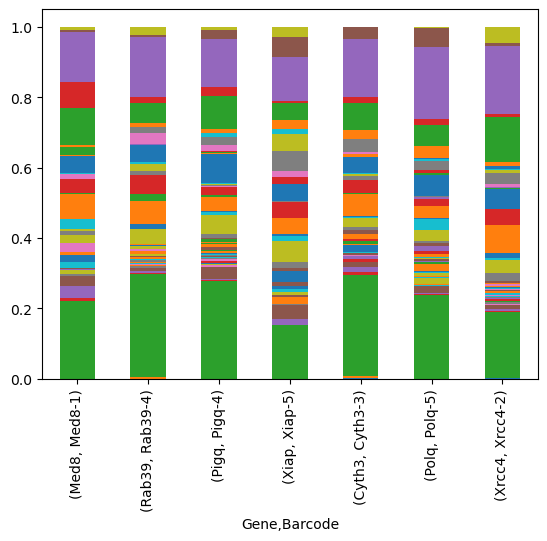

In [118]:
examples = X.loc["MB06"].index.to_series().sample(5)
ax = pd.concat((X.loc["MB06"].loc[examples],
    X.loc["MB06"].loc[[("Polq", "Polq-5"), ("Xrcc4", "Xrcc4-2")],]), axis=0).fillna(0).plot(kind='bar', stacked=True)
ax.get_legend().remove()


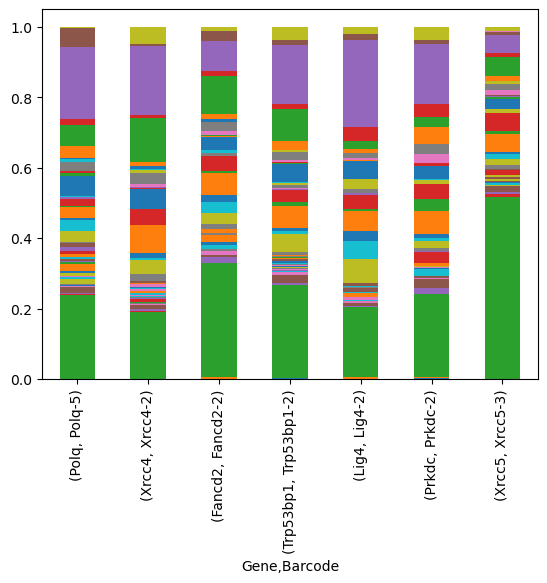

In [141]:
ax = X.loc["MB06"].loc[[("Polq", "Polq-5"), ("Xrcc4", "Xrcc4-2"), ("Fancd2", "Fancd2-2"), ("Trp53bp1", "Trp53bp1-2"), ("Lig4", "Lig4-2"), ("Prkdc", "Prkdc-2"), ("Xrcc5", "Xrcc5-3")],].fillna(0).plot(kind='bar', stacked=True)
ax.get_legend().remove()

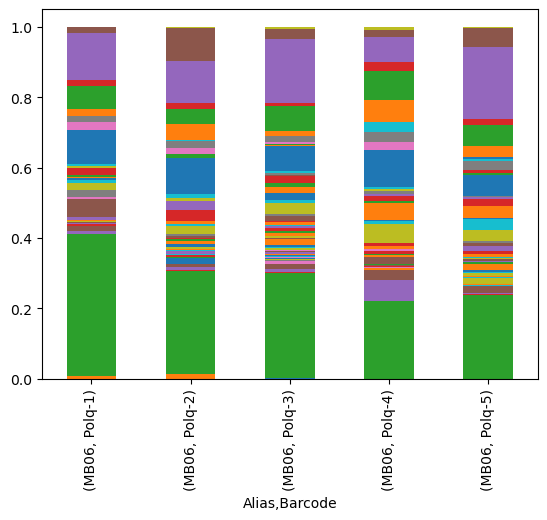

In [119]:
idx = pd.IndexSlice
ax = X.loc[idx[:,"Polq",:]].fillna(0).plot(kind='bar', stacked=True)
ax.get_legend().remove()

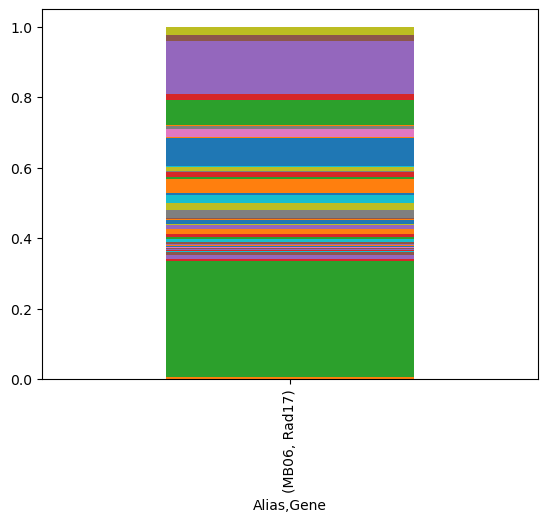

In [120]:
idx = pd.IndexSlice
ax = X.loc[idx[:,:,'Rad17-1']].fillna(0).plot(kind='bar', stacked=True)
ax.get_legend().remove()

In [121]:
X.shape

(82950, 89)

In [122]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standardise the data
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
X_st = pd.DataFrame(X_st, index=X.index, columns=X.columns)
X_st.head()

Feature                              1bp insertion - A, 0  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.491946   
                    0610009B22Rik-2             -0.600992   
                    0610009B22Rik-3             -0.600992   
                    0610009B22Rik-4             -0.014044   
                    0610009B22Rik-5             -0.373369   

Feature                              1bp insertion - C, 0  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1              0.419520   
                    0610009B22Rik-2             -0.634191   
                    0610009B22Rik-3             -0.234578   
                    0610009B22Rik-4             -0.012318   
                    0610009B22Rik-5             -0.383457   

Feature                              1bp insertion - G, 0  \
Alias Gene          Barcode                                 
MB06  0610009B22Rik 0610009B22Rik-1             -0.877810   
                    0610009B22Rik-2             -1.232827   
                    0610009B22Rik-3             -0.670865   
                    0610009B22Rik-4             -0.802078   
                    0610009B22Rik-5             -1.859686   

Feature                              1bp insertion - T, 0  >1bp insertion, 0  \
Alias Gene          Barcode                                                    
MB06  0610009B22Rik 0610009B22Rik-1             -0.651641          -1.040853   
                    0610009B22Rik-2             -0.651641          -0.452372   
                    0610009B22Rik-3              0.635474           0.236153   
                    0610009B22Rik-4              0.385157          -0.755196   
                    0610009B22Rik-5             -0.332343           1.424305   

Feature                              Deletion 0bp microhomology, 1  \
Alias Gene          Barcode                                          
MB06  0610009B22Rik 0610009B22Rik-1                       0.983819   
                    0610009B22Rik-2                       0.535221   
                    0610009B22Rik-3                       0.790638   
                    0610009B22Rik-4                       0.583689   
                    0610009B22Rik-5                       2.535807   

Feature                              Deletion 0bp microhomology, 10  \
Alias Gene          Barcode                                           
MB06  0610009B22Rik 0610009B22Rik-1                       -0.042365   
                    0610009B22Rik-2                       -0.840089   
                    0610009B22Rik-3                       -0.136880   
                    0610009B22Rik-4                        0.102407   
                    0610009B22Rik-5                        0.057065   

Feature                              Deletion 0bp microhomology, 11  \
Alias Gene          Barcode                                           
MB06  0610009B22Rik 0610009B22Rik-1                        0.880883   
                    0610009B22Rik-2                        1.090480   
                    0610009B22Rik-3                        0.019415   
                    0610009B22Rik-4                       -0.274827   
                    0610009B22Rik-5                       -0.699075   

Feature                              Deletion 0bp microhomology, 12  \
Alias Gene          Barcode                                           
MB06  0610009B22Rik 0610009B22Rik-1                        0.639317   
                    0610009B22Rik-2                       -0.487405   
                    0610009B22Rik-3                       -0.014439   
                    0610009B22Rik-4                       -0.016778   
                    0610009B22Rik-5                        0.333902   

Feature                              Deletion 0bp microhomology, 13  ...  \
Alias Gene          Barcode                                          ...   
MB06  0610009B22Ri

In [123]:
X_st.shape

(82950, 89)

In [124]:
# fit the PCA model
pca_out = PCA().fit(X_st)

# get the component variance
print("Component variance")
print(pca_out.explained_variance_ratio_)

# Cumulative proportion of variance 
print("Cumulative proportion of variance explained")
cum_variance = np.cumsum(pca_out.explained_variance_ratio_)
print(np.cumsum(pca_out.explained_variance_ratio_))

Component variance
[1.77678032e-02 1.25601149e-02 1.22429284e-02 1.21006641e-02
 1.20726018e-02 1.20468063e-02 1.20196883e-02 1.19514152e-02
 1.19419873e-02 1.18941654e-02 1.18869647e-02 1.18652620e-02
 1.18510307e-02 1.18329751e-02 1.18070256e-02 1.17897273e-02
 1.17698631e-02 1.17662067e-02 1.17427556e-02 1.17125356e-02
 1.17014070e-02 1.16850542e-02 1.16774997e-02 1.16480973e-02
 1.16146108e-02 1.15970141e-02 1.15798195e-02 1.15510769e-02
 1.15388569e-02 1.15112638e-02 1.14927828e-02 1.14858015e-02
 1.14578412e-02 1.14465272e-02 1.14373079e-02 1.14246423e-02
 1.13961303e-02 1.13889306e-02 1.13606554e-02 1.13520859e-02
 1.13366429e-02 1.13114050e-02 1.13056905e-02 1.12753622e-02
 1.12610546e-02 1.12387624e-02 1.12213889e-02 1.12192148e-02
 1.12036920e-02 1.11771493e-02 1.11637840e-02 1.11519791e-02
 1.11491886e-02 1.11394789e-02 1.11191030e-02 1.11154701e-02
 1.10916947e-02 1.10787100e-02 1.10659155e-02 1.10365592e-02
 1.10223386e-02 1.09962834e-02 1.09735638e-02 1.09703980e-02
 1.09

0.042570846443354196

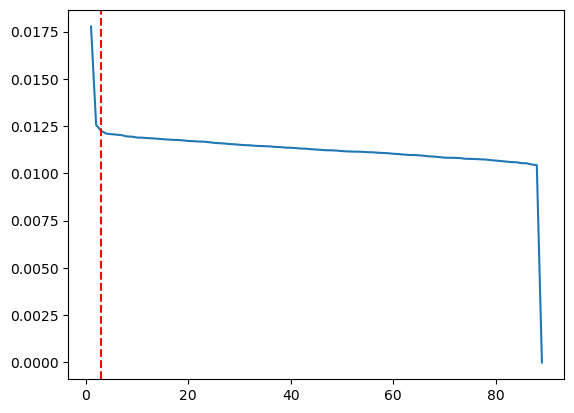

In [125]:
# scree plot

MANUALLY_SELECTED_THRESHOLD = 3
sns.lineplot(y=pca_out.explained_variance_ratio_, x=np.arange(pca_out.n_components_) + 1)
plt.axvline(MANUALLY_SELECTED_THRESHOLD, ls="--", color="red")
np.sum(pca_out.explained_variance_ratio_[:MANUALLY_SELECTED_THRESHOLD])

In [126]:
kaisers_rule = sum(pca_out.explained_variance_ > 1)
kaisers_rule

46

60


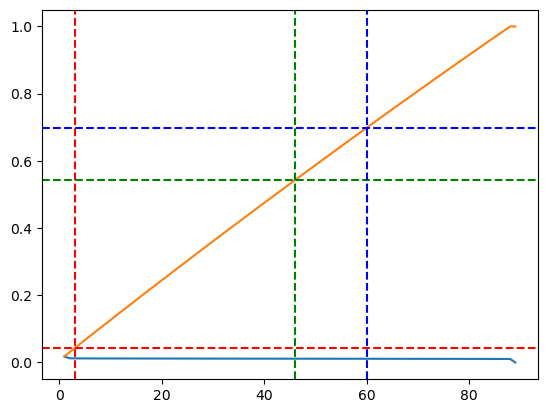

In [127]:
VARIANCE_TO_EXPLAIN = .7

var_cumsum = np.cumsum(pca_out.explained_variance_ratio_)
variance_explained_by_num_pcs = sum(var_cumsum < VARIANCE_TO_EXPLAIN)
print(variance_explained_by_num_pcs)

sns.lineplot(y=pca_out.explained_variance_ratio_, x=np.arange(pca_out.n_components_) + 1)
sns.lineplot(y=var_cumsum, x=np.arange(pca_out.n_components_) + 1)

plt.axvline(MANUALLY_SELECTED_THRESHOLD, ls="--", color="red")
plt.axhline(var_cumsum[MANUALLY_SELECTED_THRESHOLD-1], ls="--", color="red")

plt.axvline(kaisers_rule, ls="--", color="green")
plt.axhline(var_cumsum[kaisers_rule-1], ls="--", color="green")

plt.axvline(variance_explained_by_num_pcs, ls="--", color="blue")
plt.axhline(var_cumsum[variance_explained_by_num_pcs-1], ls="--", color="blue")

In [128]:
principle_components = pca_out.transform(X_st)
components_names = ["PC" + str(i+1) for i in range(principle_components.shape[1])]
pca_df = pd.DataFrame(principle_components, columns=components_names)
pca_df.shape

(82950, 89)

In [129]:
principle_components[:,0].shape

(82950,)

In [130]:
X.index.get_level_values("Alias")

Index(['MB06', 'MB06', 'MB06', 'MB06', 'MB06', 'MB06', 'MB06', 'MB06', 'MB06',
       'MB06',
       ...
       'MB06', 'MB06', 'MB06', 'MB06', 'MB06', 'MB06', 'MB06', 'MB06', 'MB06',
       'MB06'],
      dtype='object', name='Alias', length=82950)

Text(37.597222222222214, 0.5, 'PC2 - 0.013')

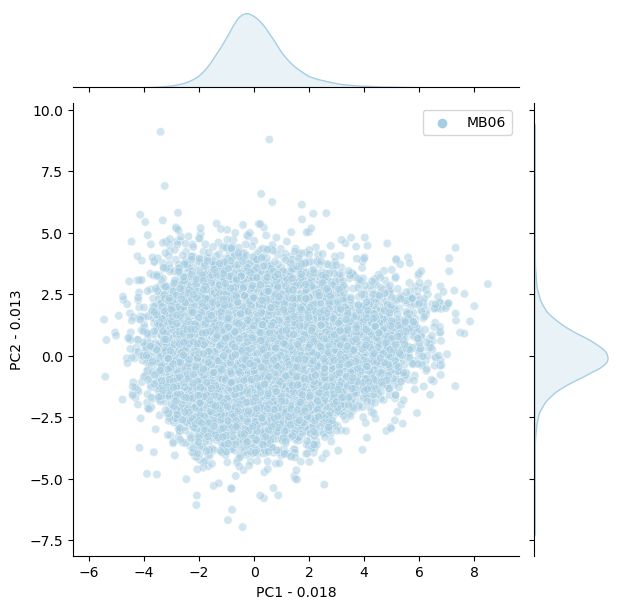

In [131]:
h = sns.jointplot(x = principle_components[:,0], y = principle_components[:,1], hue=X.index.get_level_values("Alias").to_list(), palette="Paired", alpha=.5)
h.ax_joint.set_xlabel('PC1 - {:.3f}'.format(pca_out.explained_variance_ratio_[0]))
h.ax_joint.set_ylabel('PC2 - {:.3f}'.format(pca_out.explained_variance_ratio_[1]))

<AxesSubplot:>

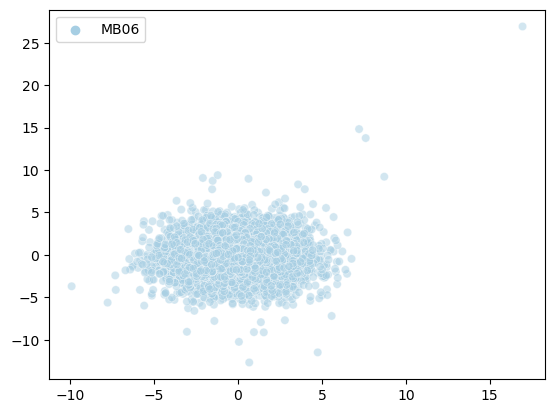

In [132]:
sns.scatterplot(x = principle_components[:,2], y = principle_components[:,3], hue=X.index.get_level_values("Alias").to_list(), palette="Paired", alpha=.5)

<AxesSubplot:>

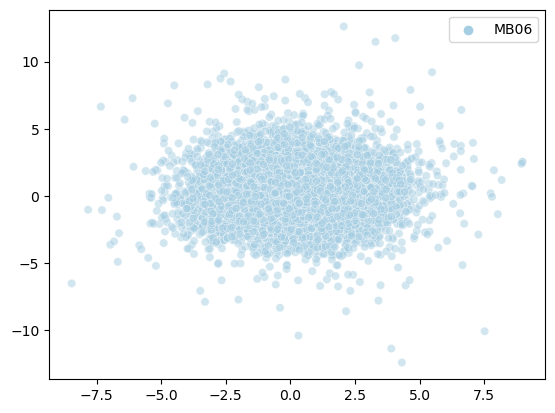

In [133]:
sns.scatterplot(x = principle_components[:,4], y = principle_components[:,5], hue=X.index.get_level_values("Alias").to_list(), palette="Paired", alpha=.5)

In [134]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i)+"{:.3f}".format(pca_out.explained_variance_ratio_[i-1]) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X_st.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC10.018,PC20.013,PC30.012,PC40.012,PC50.012,PC60.012,PC70.012,PC80.012,PC90.012,PC100.012,...,PC800.011,PC810.011,PC820.011,PC830.011,PC840.011,PC850.011,PC860.011,PC870.010,PC880.010,PC890.000
variable,,,,,,,,,,,,,,,,,,,,,
"1bp insertion - A, 0",0.062500,-0.017109,-0.140600,-0.162780,-0.061301,-0.048961,-0.003584,0.176822,0.060776,0.021589,...,-0.011925,-0.071684,0.151548,0.212534,0.069875,-0.129849,-0.075137,-0.052576,0.136781,0.041546
"1bp insertion - C, 0",0.065942,-0.088073,-0.099158,-0.141711,0.151254,0.134971,-0.143813,-0.107346,0.003429,0.189450,...,0.061298,-0.254676,-0.034243,-0.018878,0.059826,-0.042019,0.128698,-0.072884,0.222168,0.065988
"1bp insertion - G, 0",0.636661,0.204768,0.029586,0.019747,-0.003318,0.052120,0.026465,-0.000849,-0.032924,-0.054027,...,0.046187,0.103200,0.172773,0.057606,-0.060507,-0.019865,0.028382,-0.052292,-0.066490,0.487314
"1bp insertion - T, 0",0.040040,0.016622,0.046726,0.116097,-0.213996,-0.115418,0.116422,-0.074706,0.084974,0.276699,...,0.024569,-0.071644,-0.146719,-0.190412,0.139256,-0.063372,0.037736,-0.114000,-0.082058,0.044426
">1bp insertion, 0",0.166629,0.014120,-0.014501,-0.099463,-0.010749,-0.044912,0.091353,0.045627,-0.096997,-0.017802,...,-0.049452,0.030130,-0.330842,0.093102,0.075992,0.103279,-0.160415,0.085799,0.055955,0.093215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Homology Directed Repair, 0",-0.500740,0.634422,0.002034,-0.095944,-0.019235,0.024353,0.059975,0.015749,0.094878,0.038672,...,-0.007319,-0.033812,-0.040019,-0.008653,-0.014149,0.050313,0.022275,0.009047,0.008190,0.441698
"Large Deletion, 0",-0.050132,-0.111471,-0.138007,-0.050009,-0.075723,-0.075645,0.069469,-0.276624,0.213800,0.020696,...,0.091253,0.047535,0.134085,0.118736,0.024184,-0.013831,-0.058877,0.091063,0.115718,0.146753
"Tandem Duplication plus, 0",-0.002792,0.019176,-0.127336,0.072685,0.199796,0.056764,-0.005462,0.053117,0.092474,-0.092040,...,-0.046286,-0.247828,0.027541,0.140085,0.149068,-0.180388,-0.001244,-0.066465,0.109856,0.012341


In [135]:
pca_scores = pca_out.transform(X_st)
pca_scores_df = pd.DataFrame(pca_scores, columns=pc_list, index=X_st.index)
pca_scores_df.head()

PC10.018  PC20.013  PC30.012  PC40.012  \
Alias Gene          Barcode                                                   
MB06  0610009B22Rik 0610009B22Rik-1 -1.272871 -1.005706  1.537441  0.251812   
                    0610009B22Rik-2 -1.773878 -0.885182  1.384498 -1.445148   
                    0610009B22Rik-3 -0.682950 -0.176951 -0.316085 -0.525494   
                    0610009B22Rik-4 -1.478084  0.674083  0.572034  0.353583   
                    0610009B22Rik-5 -1.439019  0.075630 -1.306191  1.025786   

                                     PC50.012  PC60.012  PC70.012  PC80.012  \
Alias Gene          Barcode                                                   
MB06  0610009B22Rik 0610009B22Rik-1  0.200866  0.363388 -0.175816 -0.531191   
                    0610009B22Rik-2  0.887628 -0.385364  0.623260 -0.721274   
                    0610009B22Rik-3  0.046719  0.438731 -0.314376 -0.023705   
                    0610009B22Rik-4  0.704487 -0.439576  0.330800  1.014477   
                    0610009B22Rik-5  0.729687 -0.231006  1.355197 -0.006690   

                                     PC90.012  PC100.012  ...  PC800.011  \
Alias Gene          Barcode                               ...              
MB06  0610009B22Rik 0610009B22Rik-1  0.278214   0.271295  ...   1.501649   
                    0610009B22Rik-2  0.106677   0.612289  ...   0.057247   
                    0610009B22Rik-3 -0.713800   0.965983  ...  -0.107190   
                    0610009B22Rik-4  0.483577  -1.066242  ...  -0.185328   
                    0610009B22Rik-5  0.861908  -0.288181  ...  -0.139349   

                                     PC810.011  PC820.011  PC830.011  \
Alias Gene          Barcode                                            
MB06  0610009B22Rik 0610009B22Rik-1  -1.085845   0.268344   0.184523   
                    0610009B22Rik-2  -0.833022  -0.670851   0.671269   
                    0610009B22Rik-3   0.619850  -0.012325  -0.137678   
                    0610009B22Rik-4   0.076890   0.173804  -1.168761   
                    0610009B22Rik-5  -0.571496  -0.209978  -1.649081   

                                     PC840.011  PC850.011  PC860.011  \
Alias Gene          Barcode                                            
MB06  0610009B22Rik 0610009B22Rik-1   0.883345  -0.103957   0.247329   
                    0610009B22Rik-2   0.259912  -0.686425   0.428126   
                    0610009B22Rik-3  -0.010448   0.491988   0.366187   
                    0610009B22Rik-4   0.005334   0.496254  -0.007147   
                    0610009B22Rik-5   1.242045   1.076763   0.211303   

                                     PC870.010  PC880.010     PC890.000  
Alias Gene          Barcode                                              
MB06  0610009B22Rik 0610009B22Rik-1   0.294369   0.074462 -1.577492e-16  
                    0610009B22Rik-2   0.131671  -0.605086 -1.040776e-16  
                    0610009B22Rik-3   0.547326  -0.920987  1.326749e-15  
                    0610009B22Rik-4  -0.056238  -0.127032  8.005162e-16  
                    0610009B22Rik-5   0.328987   0.019555  2.185891e-15  

[5 rows x 89 columns]

<AxesSubplot:ylabel='variable'>

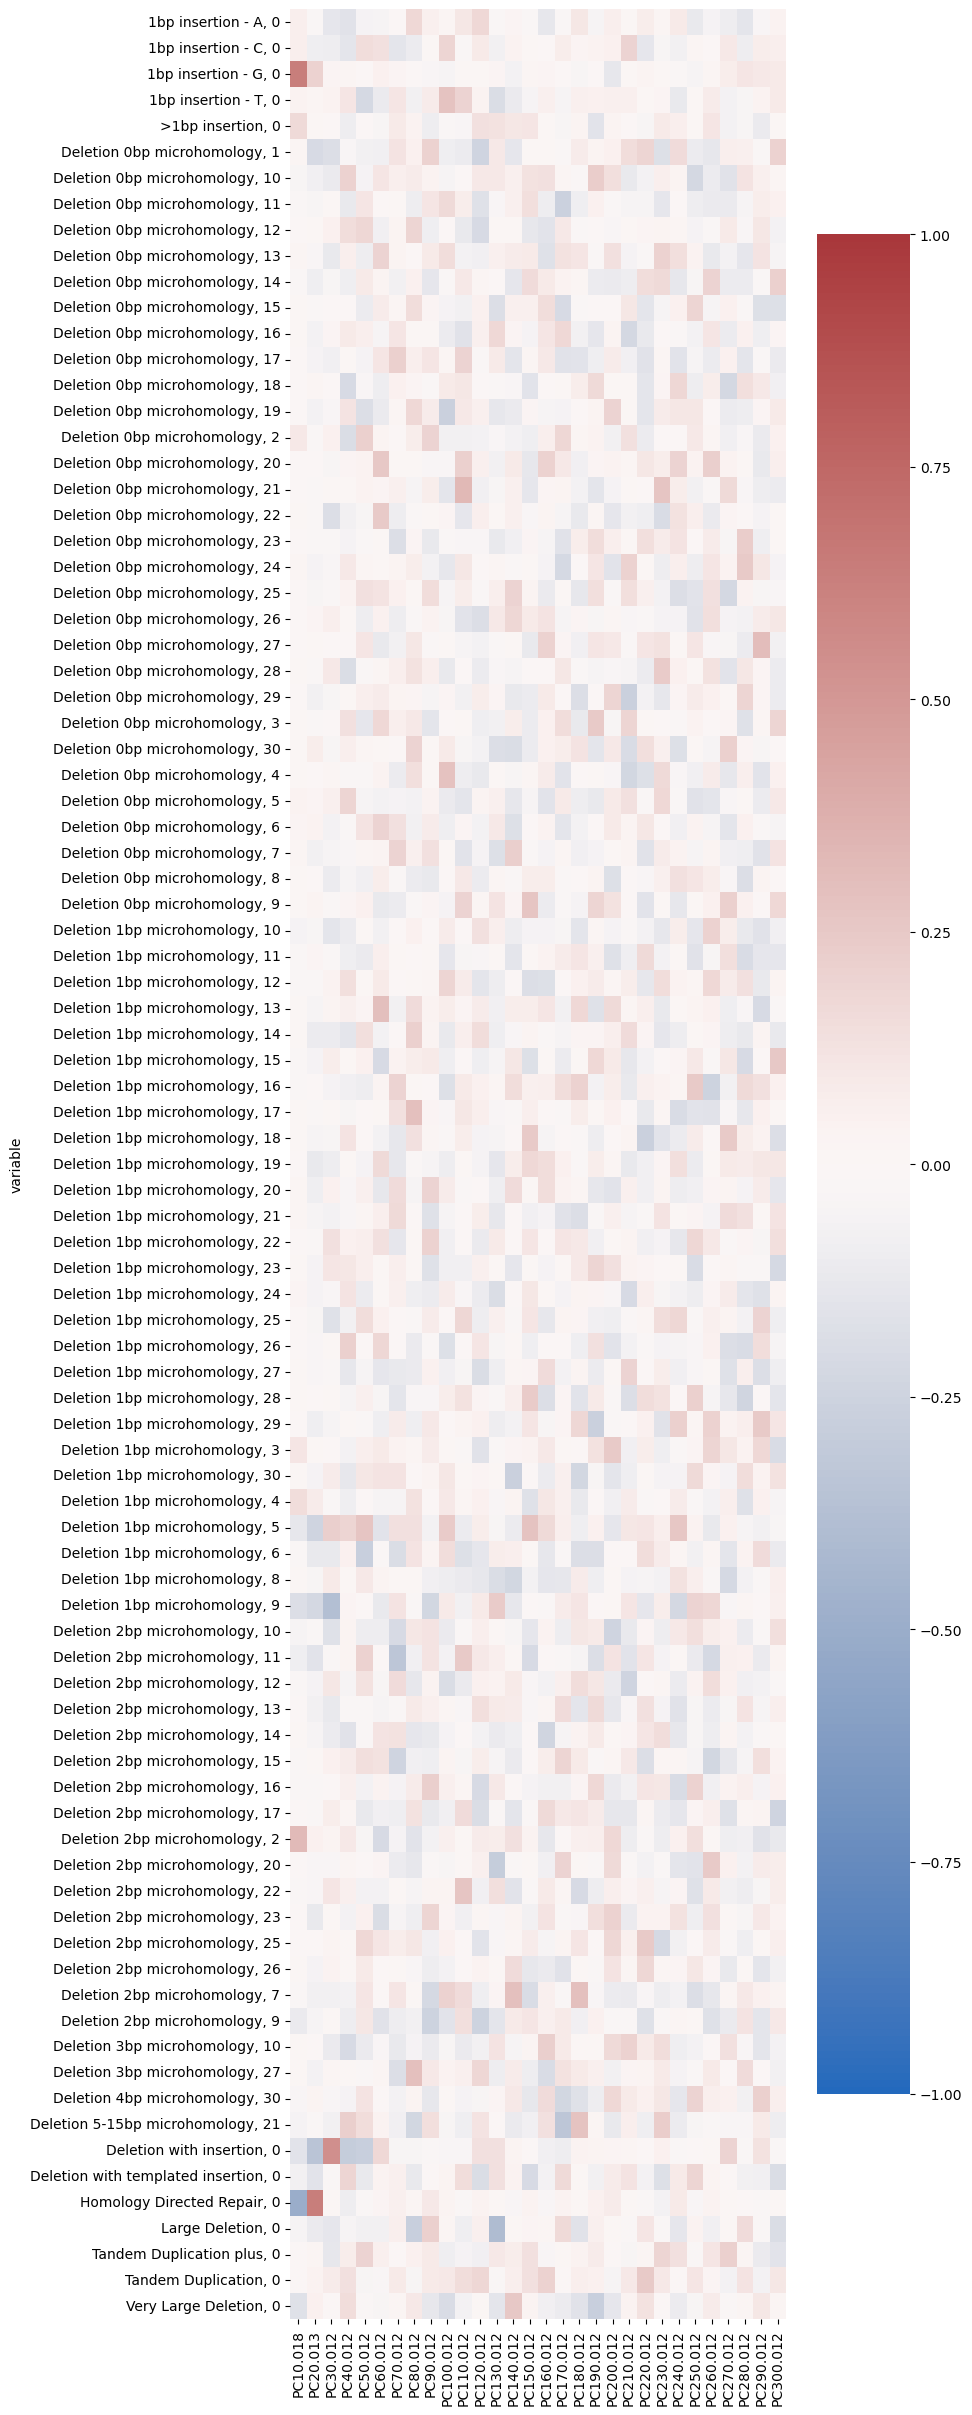

In [136]:
plt.figure(figsize=(8, 30))
sns.heatmap(loadings_df.iloc[:,:30], center=0, vmin=-1, vmax=1, cmap="vlag")

In [137]:
from bioinfokit.visuz import cluster

# get 2D biplot
cluster.biplot(cscore=pca_scores[np.random.choice(pca_scores.shape[0], 10000, replace=False), :], loadings=loadings, labels=X.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2), show=False, dim=(30,30), figtype="pdf")


In [138]:

# cluster.pcaplot(x=loadings[0], y=loadings[1], labels=X.columns.values, 
#     var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
#     var2=round(pca_out.explained_variance_ratio_[1]*100, 2), show=False, dim=(30,30), figtype="pdf")